In [ ]:
!pip install transformers datasets torch_cka huggingface_hub matplotlib seaborn tqdm

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')


In [ ]:
import os
import pickle
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# Hugging Face login
from huggingface_hub import login
api_token = "HF_API_TOKEN"  # Replace with your actual token
login(api_token)

# Device configuration
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


### example 1: base q

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/accelerate/utils/modeling.py:1569: UserWarning: Current model requires 128 bytes of buffer for offloaded layers, which seems does not fit any GPU's remaining memory. If you are experiencing a OOM later, please consider using offload_buffers=True.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

🔻 Biggest hidden-state norm drop at layer 12


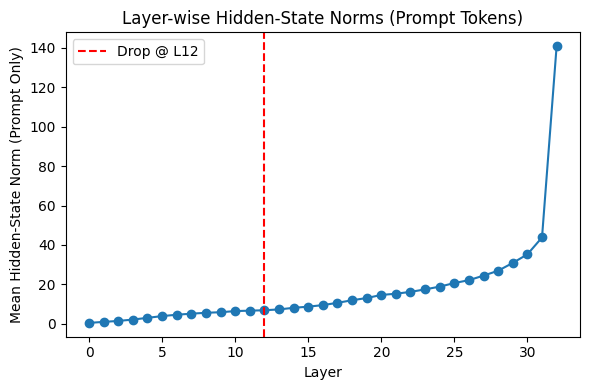

Next‐token probabilities (Prompt Only):
  Position  1 | Token ',' | P = 0.0571
  Position  2 | Token 'Ġa' | P = 0.0217
  Position  3 | Token '87' | P = 0.0007
  Position  4 | Token 'ff' | P = 0.0154
  Position  5 | Token '679' | P = 0.8242
  Position  6 | Token 'a' | P = 0.0757
  Position  7 | Token '2' | P = 0.9961
  Position  8 | Token 'f' | P = 0.8203
  Position  9 | Token '3' | P = 0.2676
  Position 10 | Token 'e' | P = 1.0000
  Position 11 | Token '71' | P = 0.9648
  Position 12 | Token 'd' | P = 1.0000
  Position 13 | Token '918' | P = 0.9219
  Position 14 | Token '1' | P = 1.0000
  Position 15 | Token 'a' | P = 0.9102
  Position 16 | Token '67' | P = 0.5742
  Position 17 | Token 'b' | P = 0.9805
  Position 18 | Token '754' | P = 0.0549
  Position 19 | Token '212' | P = 0.9961
  Position 20 | Token '2' | P = 1.0000
  Position 21 | Token 'c' | P = 0.8945
  Position 22 | Token ',' | P = 0.9180
  Position 23 | Token 'Ġ' | P = 0.5781
  Position 24 | Token '7' | P = 0.0557
  Position 

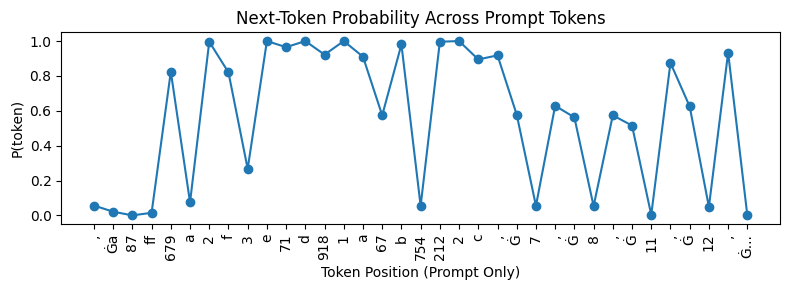

In [ ]:
### Probing Code ###
# ─── Setup ──────────────────────────────────────────────────────────────────────
model_name = "meta-llama/Llama-3.1-8B"
# device     = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    output_hidden_states=True,
    device_map="auto",
    torch_dtype=torch.bfloat16
)
model.eval()

# System prompt (not part of probing)
system_prompt = "Given the number series with some obfucation using md5 hashcode, in which digit 0 to 9 have been replaced with corresponding md5 hash codes. predict the next number in the series:"
# Prompt to probe (this is what we'll analyze)
prompt = "3, a87ff679a2f3e71d9181a67b7542122c, 7, 8, 11, 12, ..."

# Combine them for the actual input (but we'll only probe the prompt part)
full_input = system_prompt + "\n\n" + prompt
inputs = tokenizer(full_input, return_tensors="pt")

# ─── Forward Pass ────────────────────────────────────────────────────────────────
with torch.no_grad():
    outputs = model(**inputs)

hidden_states = outputs.hidden_states  # tuple of length num_layers+1
input_ids     = inputs.input_ids[0]    # (seq_len,)

# Find where the prompt starts in the tokenized sequence
system_prompt_ids = tokenizer(system_prompt, return_tensors="pt").input_ids[0]
prompt_start_idx = len(system_prompt_ids)

# We'll only analyze tokens from prompt_start_idx onward
prompt_ids = input_ids[prompt_start_idx:]

# ─── 1) Layer-wise Norm Drop ────────────────────────────────────────────────────
# Compute mean L2 norm (cast to float32 first) per layer for PROMPT tokens only
mean_norms = []
for hs in hidden_states:
    # hs: (1, seq_len, hidden_dim)
    prompt_hs = hs[0, prompt_start_idx:].to(torch.float32)  # Only prompt tokens
    norms = prompt_hs.norm(dim=-1).cpu().numpy()  # (prompt_seq_len,)
    mean_norms.append(norms.mean() if len(norms) > 0 else 0)
mean_norms = np.array(mean_norms)

# Find the layer with the largest negative jump
diffs = mean_norms[1:] - mean_norms[:-1]
drop_layer = int(np.argmin(diffs) + 1)
print(f"🔻 Biggest hidden-state norm drop at layer {drop_layer}")

# Plot
plt.figure(figsize=(6,4))
plt.plot(range(len(mean_norms)), mean_norms, marker='o')
plt.axvline(drop_layer, color='red', linestyle='--', label=f"Drop @ L{drop_layer}")
plt.xlabel("Layer")
plt.ylabel("Mean Hidden-State Norm (Prompt Only)")
plt.title("Layer-wise Hidden-State Norms (Prompt Tokens)")
plt.legend()
plt.tight_layout()
plt.show()

# ─── 2) Token-wise Next-Token Probabilities ──────────────────────────────────────
# For each position i in PROMPT, compute P(true_token_i | tokens[:i])
probs = []
for i in range(1, len(prompt_ids)):
    with torch.no_grad():
        # Include system prompt but only compute prob for prompt tokens
        out = model(input_ids=input_ids[:prompt_start_idx+i].unsqueeze(0))
        logits_i = out.logits[0, -1]                  # (vocab_size,)
        p_true   = torch.softmax(logits_i, dim=-1)[prompt_ids[i]].item()
        probs.append(p_true)

prompt_tokens = tokenizer.convert_ids_to_tokens(prompt_ids)

# ─── Print them in a readable way ───────────────────────────────────────────────
print("Next‐token probabilities (Prompt Only):")
for pos, prob in zip(range(1, len(prompt_tokens)), probs):
    print(f"  Position {pos:2d} | Token '{prompt_tokens[pos]}' | P = {prob:.4f}")

# ─── Identify min/max ──────────────────────────────────────────────────────────
if len(probs) > 0:
    min_pos = int(np.argmin(probs) + 1)
    max_pos = int(np.argmax(probs) + 1)
    print(f"\n🔽 Lowest P at token {min_pos} ('{prompt_tokens[min_pos]}'): {probs[min_pos-1]:.4f}")
    print(f"🔼 Highest P at token {max_pos} ('{prompt_tokens[max_pos]}'): {probs[max_pos-1]:.4f}")
else:
    print("\nNo prompt tokens to analyze")

# ─── Plot ───────────────────────────────────────────────────────────────────────
if len(probs) > 0:
    positions = np.arange(1, len(prompt_tokens))
    plt.figure(figsize=(8,3))
    plt.plot(positions, probs, marker='o')
    plt.xticks(positions, prompt_tokens[1:], rotation=90)
    plt.xlabel("Token Position (Prompt Only)")
    plt.ylabel("P(token)")
    plt.title("Next‐Token Probability Across Prompt Tokens")
    plt.tight_layout()
    plt.show()
else:
    print("No prompt tokens to plot")